In [1]:
# !pip install python-docx

In [2]:
import glob
import os
import random
import math
import ast
import docx
import scipy
import cv2
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from datetime import datetime
from scipy.spatial.distance import cdist

# Comparison ArUco and CVAT
- Part 1: Combine data and filtering steps\
- Part 2: Filtering, cleaning and combining
- Part 3: cleaning and processing combined datasets, finally exporting df


# Part 1: Combine data and filtering steps

by : Arjen van Putten, Utrecht University, e-mail: a.vanputten1@uu.nl
Here we examine the results of ArUco tracking by comparing it to manual annotations.


### Dataset
The data used for the analysis was collected during phase 1 of the Imagen project. This data is of maximum 10 hens in small floor pens with options for hiding and perching. The data is collected within weeks after placing the ArUco markers on the hens, so the quality of the tags should be high. We do expect lower tracking due to feathers covering the ArUco markers.


### The types of data used:

1.  CVAT data: The manually annotated positions of the hens in the form of bounding boxes at 1 Hz.
    - the dataset has on every row: frame nr, ArUco ID, left upper corner x, left upper corner y, box width, box height, confidence interval (always 1), class (always 1 for Chicken, we used 1 class), visible (1 or 0), z.
    - the files are exported from the annotation platform (CVAT) in the format MOT. This produces a file called gt per video. Manually we added the original video filename to this txt file name. Instead of gt.txt for every file we call them gt_{videoname}.txt so for instance gt_03_20220108075951_part2_6.txt.
    
2.  ArUco data: The ArUco positions tracked by running OpenCV (opencv-contrib-python==4.5.5.64) on the original videos. collected at 20Hz.
    - on the rows of the dataset: frame time in MS**, frame number***, pixel coordinates of top left corner, pixel coordinates of top right,  corner, pixel coordinates of bottom right corner, pixel coordinates of bottom left corner.
    - all files are stored in csv format, with '_ArUco_tracks.csv' after the original video name without .mp4
    
    
** for extracting the time of every frame we used the following code in the standard ArUco tracking script:    
    ret, frame = video.read()  t = video.get(cv2.CAP_PROP_POS_MSEC)
*** for the frame number we added f = video.get(cv2.CAP_PROP_POS_FRAMES)
    
3. The Overview of all files: in order to align identity and control the quality.

In order to merge these dataset, we need to have 3 items for the comparison:
- the name of the used video
- a conversion table with the ArUco ID and the ID given to the birds
- similar timestamp information in the datasets. Here we use the frame number on the videos. Important: On CVAT, only every 20th frame is used, so we need to multiply the frame number by 20.

4. The pen dimensions per pen

# overview of all filtering steps:
- all ArUco positions outside of the pens are removed. Our cameras captured other pens through the fences. If not within the area between the corners of the pen, then the ArUco is removed.
- empty ArUco ID values are removed from the overview file after importing and melting, these animals don't exist
- all manual bounding box annotations from the CVAT dataset are reduced to 1Hz. Most of them were 1 Hz already.
- the duration of the CVAT bounding box annotations are used as the threshold for the maximum analyzed frame, to make the ArUco and bounding box tracking datasets the same length. 
- for examining if the marker is detected on an animal which is visible to the annotator, we interpolated the visibility of the manual bounding box annoations (1Hz) to the ArUco detections (20Hz) using the nearest method. Since this method does not interpolate the first values the same as the last, we first copy the first recorded visibility value to the first frame with a detected ArUco and then interpolate.

In [3]:
workdir = 'C:/Users/Putte027/OneDrive - Universiteit Utrecht/Documents/data/CVAT_vs_ArUco/final/'

In [4]:
os.chdir(workdir)

# Part 1 - import and clean the 4 data sources

Importing data from: \
1.1 CVAT \
1.2 ArUco \
1.3 overview with information for merging\
1.4 pen border for filtering in chapter 2

## 1.1 Importing CVAT Data
import all bounding box annotations exported from the program CVAT

In [5]:
# here I add the original folder location for the downloaded CVAT files:
path_cvat = 'MOT/' #str(workdir +'MOT/')
# now we list all text files so we can read them all at once in the next step:
file_list_cvat = [os.path.normpath(filename) \
                  for filename in glob.iglob(path_cvat + '**/*.txt',\
                                             recursive=True)]
# just in case if we need to select a subset, then we'll keep the same order:
file_list_cvat = sorted(file_list_cvat)
# now we load the data into a dataframe
# since all datasets have the same structure, we need to identify the rows correctly
# we add the original filepath to every row to distinguish between the different sets
cvat_df = pd.concat([pd.read_csv(x,\
                                 names=['frame_tracked', 'ID', 'bb_left',\
                                        'bb_top', 'bb_width', 'bb_height',\
                                        'conf', 'class', 'visible']\
                                 ).assign(path_and_filename=str(x.replace("\\","/"))\
                                         ) for x in file_list_cvat])
# after making the data frame we add a column with the video name for later use
cvat_df['video'] = cvat_df.path_and_filename.apply(lambda x: x.split('/')[-1][3:-4])
# let's take a look by sampling 10 random rows
cvat_df.sample(10)

,frame_tracked,ID,bb_left,bb_top,bb_width,bb_height,conf,class,visible,path_and_filename,video
474,53,7,261.60,590.90,249.20,144.10,1,1,1.0,MOT/gt_06_20211217112157_part1_7.txt,06_20211217112157_part1_7
768,79,4,159.40,816.30,218.90,244.50,1,1,1.0,MOT/gt_11_20220108105951_part1_6.txt,11_20220108105951_part1_6
1046,120,2,386.01,308.00,133.90,227.79,1,1,1.0,MOT/gt_05_20220108114710_part_6.txt,05_20220108114710_part_6
862,87,3,350.40,591.80,158.40,246.00,1,1,1.0,MOT/gt_07_20220108115953_part2_3.txt,07_20220108115953_part2_3
775,78,6,186.90,283.90,295.30,188.20,1,1,0.0,MOT/gt_02_20220111065955_part2_WB.txt,02_20220111065955_part2_WB
769,77,10,1528.70,574.40,16.32,57.00,1,1,0.0,MOT/gt_01_20220108115951_part1_6.txt,01_20220108115951_part1_6
369,42,1,306.40,847.30,220.50,137.20,1,1,1.0,MOT/gt_p02t_06_20220112171551_1.txt,p02t_06_20220112171551_1
950,96,3,496.73,615.33,301.87,121.67,1,1,1.0,MOT/gt_01_20220108115951_part1_1.txt,01_20220108115951_part1_1
596,61,2,495.00,535.00,177.10,299.50,1,1,1.0,MOT/gt_p01t_07_20220102074423_3.txt,p01t_07_20220102074423_3
419,53,1,331.50,563.10,294.20,187.90,1,1,1.0,MOT/gt_01_20220110073318_2.txt,01_20220110073318_2


## 1.2 Importing ArUco Data
## import, adapt data type and explore all ArUco data

### 1.2.A import the data
Import all files, add the filename as a column at the same time to keep them apart and extract the video name from that file path.

In [6]:
# here I add the original folder location for the downloaded CVAT files:
path_ArUco = 'ArUco/' #str(workdir +'ArUco/')
# now we list all files so we can read them all at once in the next step:
file_list_ArUco = [os.path.normpath(filename) \
                   for filename in glob.iglob(path_ArUco + '**/*.csv',\
                                              recursive=True)]
# just in case if we need to select a subset, then we'll keep the same order:
file_list_ArUco = sorted(file_list_ArUco)
# now we load the data into a dataframe
# since all datasets have the same structure, we need to identify the rows correctly
# we add the original filepath to every row to distinguish between the different sets
ArUco_df = pd.concat([pd.read_csv(x).assign(path_and_filename=str(x.replace("\\","/")))\
                      for x in file_list_ArUco])
# after making the data frame we add a column with the video name for later use
ArUco_df['video'] = ArUco_df.path_and_filename.apply(lambda x: x.split('/')[-1][:-17])
# see how it looks:
ArUco_df.sample(10)

,time_MS,frame,ID,top_left,top_right,bottom_right,bottom_left,path_and_filename,video
4306,65863.0,1319.0,20.0,"(657.0, 1004.0)","(654.0, 1032.0)","(625.0, 1029.0)","(628.0, 1000.0)",ArUco/11_20220108105951_part1_5_ArUco_tracks.csv,11_20220108105951_part1_5
14952,97575.0,1953.0,19.0,"(145.0, 685.0)","(158.0, 661.0)","(169.0, 673.0)","(156.0, 696.0)",ArUco/07_20220108115953_part2_5_ArUco_tracks.csv,07_20220108115953_part2_5
7161,51387.0,1029.0,4.0,"(238.0, 717.0)","(226.0, 695.0)","(245.0, 680.0)","(258.0, 702.0)",ArUco/01_20220108115951_part1_6_ArUco_tracks.csv,01_20220108115951_part1_6
7393,45694.0,916.0,10.0,"(1149.0, 465.0)","(1121.0, 452.0)","(1133.0, 424.0)","(1161.0, 437.0)",ArUco/02_20220111065955_part2_WA_ArUco_tracks.csv,02_20220111065955_part2_WA
11980,109318.0,2189.0,4.0,"(1039.0, 680.0)","(1052.0, 653.0)","(1079.0, 665.0)","(1066.0, 692.0)",ArUco/03_20220108075951_part2_1_ArUco_tracks.csv,03_20220108075951_part2_1
17106,109491.0,2191.0,5.0,"(941.0, 565.0)","(915.0, 550.0)","(928.0, 523.0)","(954.0, 539.0)",ArUco/02_20220111065955_part2_WB_ArUco_tracks.csv,02_20220111065955_part2_WB
5576,43908.0,879.0,5.0,"(711.0, 456.0)","(726.0, 477.0)","(704.0, 488.0)","(688.0, 467.0)",ArUco/p01t_07_20220102074423_2_ArUco_tracks.csv,p01t_07_20220102074423_2
2044,15196.0,305.0,1.0,"(330.0, 538.0)","(314.0, 522.0)","(324.0, 502.0)","(341.0, 519.0)",ArUco/01_20220108115951_part1_8_ArUco_tracks.csv,01_20220108115951_part1_8
7075,110692.0,2216.0,11.0,"(378.0, 529.0)","(368.0, 504.0)","(390.0, 491.0)","(400.0, 516.0)",ArUco/01_20220110073318_2_ArUco_tracks.csv,01_20220110073318_2
7235,69263.0,1387.0,16.0,"(1830.0, 861.0)","(1822.0, 829.0)","(1854.0, 815.0)","(1862.0, 847.0)",ArUco/06_20211217112157_part1_7_ArUco_tracks.csv,06_20211217112157_part1_7


### 1.2.B removing a problematic column

In [7]:
# Looking at the data frame, we see some values at the end with a high frame and time 0.0
# aside from time_MS, all data seems to be fine. Therefore we remove this column only.
ArUco_df = ArUco_df.drop(['time_MS'], axis=1)

### 1.2.C extract coordinates to correct format
Change the data type tuple of the marker coordinates to separate column values. 

In [8]:
# change the format of the coordinates from tuple to separate columns.
# this step takes a while

# first we change the data type to literal_eval so we can change it to a list in the next step.
ArUco_df['top_left'] = ArUco_df.top_left.apply(lambda x: ast.literal_eval(x) if x is not np.nan else np.nan)
ArUco_df['top_right'] = ArUco_df.top_right.apply(lambda x: ast.literal_eval(x) if x is not np.nan else np.nan)
ArUco_df['bottom_right'] = ArUco_df.bottom_right.apply(lambda x: ast.literal_eval(x) if x is not np.nan else np.nan)
ArUco_df['bottom_left'] = ArUco_df.bottom_left.apply(lambda x: ast.literal_eval(x) if x is not np.nan else np.nan)

# second we change these values to lists and separate the values in an x and y column per marker corner.
ArUco_df[['tl_x', 'tl_y']] = pd.DataFrame(ArUco_df['top_left'].tolist(), index=ArUco_df.index)
ArUco_df[['tr_x', 'tr_y']] = pd.DataFrame(ArUco_df['top_right'].tolist(), index=ArUco_df.index)
ArUco_df[['br_x', 'br_y']] = pd.DataFrame(ArUco_df['bottom_right'].tolist(), index=ArUco_df.index)
ArUco_df[['bl_x', 'bl_y']] = pd.DataFrame(ArUco_df['bottom_left'].tolist(), index=ArUco_df.index)

# check if it looks correct:
ArUco_df.sample(10)

,frame,ID,top_left,top_right,bottom_right,bottom_left,path_and_filename,video,tl_x,tl_y,tr_x,tr_y,br_x,br_y,bl_x,bl_y
5972,781.0,2.0,"(1207.0, 603.0)","(1225.0, 579.0)","(1250.0, 597.0)","(1231.0, 621.0)",ArUco/01_20220108115951_part1_5_ArUco_tracks.csv,01_20220108115951_part1_5,1207.0,603.0,1225.0,579.0,1250.0,597.0,1231.0,621.0
7787,1674.0,20.0,"(889.0, 584.0)","(915.0, 594.0)","(908.0, 622.0)","(882.0, 612.0)",ArUco/06_20211217112157_part1_6_ArUco_tracks.csv,06_20211217112157_part1_6,889.0,584.0,915.0,594.0,908.0,622.0,882.0,612.0
4195,1065.0,14.0,"(637.0, 766.0)","(610.0, 757.0)","(620.0, 735.0)","(647.0, 744.0)",ArUco/06_20211217112157_part1_8_ArUco_tracks.csv,06_20211217112157_part1_8,637.0,766.0,610.0,757.0,620.0,735.0,647.0,744.0
11626,1715.0,12.0,"(476.0, 956.0)","(469.0, 933.0)","(490.0, 935.0)","(497.0, 959.0)",ArUco/06_20211217112157_part1_3_ArUco_tracks.csv,06_20211217112157_part1_3,476.0,956.0,469.0,933.0,490.0,935.0,497.0,959.0
14129,1835.0,6.0,"(786.0, 720.0)","(774.0, 749.0)","(749.0, 737.0)","(760.0, 708.0)",ArUco/02_20220111065955_part2_WC_ArUco_tracks.csv,02_20220111065955_part2_WC,786.0,720.0,774.0,749.0,749.0,737.0,760.0,708.0
3546,1485.0,3.0,"(704.0, 664.0)","(681.0, 652.0)","(694.0, 629.0)","(717.0, 641.0)",ArUco/02_20220111112402_part2_ArUco_tracks.csv,02_20220111112402_part2,704.0,664.0,681.0,652.0,694.0,629.0,717.0,641.0
11449,1797.0,13.0,"(350.0, 697.0)","(334.0, 703.0)","(322.0, 679.0)","(338.0, 673.0)",ArUco/07_20220108115953_part2_6_ArUco_tracks.csv,07_20220108115953_part2_6,350.0,697.0,334.0,703.0,322.0,679.0,338.0,673.0
18011,2214.0,2.0,"(560.0, 537.0)","(546.0, 511.0)","(572.0, 497.0)","(585.0, 523.0)",ArUco/02_20220111065955_part2_WA_ArUco_tracks.csv,02_20220111065955_part2_WA,560.0,537.0,546.0,511.0,572.0,497.0,585.0,523.0
8277,1181.0,14.0,"(1377.0, 583.0)","(1358.0, 607.0)","(1335.0, 588.0)","(1354.0, 564.0)",ArUco/06_20211217112157_part1_5_ArUco_tracks.csv,06_20211217112157_part1_5,1377.0,583.0,1358.0,607.0,1335.0,588.0,1354.0,564.0
3754,514.0,7.0,"(229.0, 863.0)","(220.0, 837.0)","(240.0, 832.0)","(249.0, 858.0)",ArUco/01_20220108115951_part1_8_ArUco_tracks.csv,01_20220108115951_part1_8,229.0,863.0,220.0,837.0,240.0,832.0,249.0,858.0


# 1.3 Importing Overview Data
# import the Overview file for the data

In the next cells we:
1. import the file holding the information on CVAT and ArUco data, this file is made by our team
2. change the shape of the data frame by melting
3. Filtering steps: 
    - delete rows without an animal ArUco ID. Due to a different number of animals per pen and the use of a melting functions, rows for missing ArUco ID as filled in by hand are now in the overview. They need to be removed.
    - we change the letter 'u' for undetected or obstructed to the value 9999 and first make a boolean column for marker obstructed (if True it's obstructed).

### 1.3.A import bounding boxes as exported from CVAT

In [9]:
# specify the location of the overview file
# this file was made by running the script: visualize_CVAT_and_ArUco.ipynb and filling in the columns by hand
# it also contains information on the annotations from the TUe overview files
overview_path = 'overview_CVAT_data4.csv' #str(workdir +'overview_CVAT_data3.csv')
# now we read it into a pandas data frame
overview_df = pd.read_csv(overview_path, sep=';')
# let's have a look:
overview_df

,video_name,original_video,part,start_time,task_CVAT,Hz_CVAT,annotator,checked,duration_sec,video_available,...,CVAT_2,CVAT_3,CVAT_4,CVAT_5,CVAT_6,CVAT_7,CVAT_8,CVAT_9,CVAT_10,CVAT_11
0,02_20220111112402_part2,02_20220111112402_part2,NaN,11:57:49,676,20,C,True,123,True,...,3,9,5,6,4,10,u,u,NaN,NaN
1,01_20220108115951_part1_1,01_20220108115951_part1,1.0,11:59:51,724,2,A,True,120,True,...,1,3,4,5,6,u,8,9,2,NaN
2,01_20220108115951_part1_2,01_20220108115951_part1,2.0,12:01:51,725,1,B,True,120,True,...,2,3,4,6,7,8,9,12,u,NaN
3,01_20220108115951_part1_3,01_20220108115951_part1,3.0,12:03:50,726,1,A,True,121,True,...,8,12,9,4,2,1,7,3,5,10
4,01_20220108115951_part1_4,01_20220108115951_part1,4.0,12:05:49,727,1,B,True,121,True,...,2,12,4,5,6,7,8,9,10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,02_20220111065954_part2_BD,02_20220111065954_part2,4.0,07:41:08,843,1,A,True,120,True,...,8,u,u,u,1,3,u,u,2,NaN
61,02_20220111065954_part2_BE,02_20220111065954_part2,5.0,07:43:09,844,1,A,True,120,True,...,u,u,u,u,1,u,u,u,u,NaN
62,02_20220111065955_part2_WA,02_20220111065955_part2,1.0,07:34:06,845,1,B,True,120,True,...,2,3,u,5,6,7,8,9,10,NaN
63,02_20220111065955_part2_WB,02_20220111065955_part2,2.0,07:36:05,846,1,B,True,120,True,...,2,3,4,5,6,7,8,9,10,NaN


### 1.3.B melt the overview data into a long format:

In [10]:
# in this cell we change the shape of overview_df to a long format using a melt function.
# first we select the columns which we need to melt, the identity columns.
# Only the identity columns hold the string 'CVAT_'.
value_cols = [col for col in overview_df.keys().to_list() if 'CVAT_' in col]
# we also list the other columns for our melt function.
id_cols = [col for col in overview_df.keys().to_list() if 'CVAT_' not in col]
# now we melt the data frame using the lists made above.
conv_df = pd.melt(overview_df, id_vars=id_cols, value_vars=value_cols, var_name='ID_CVAT', value_name='ID_ArUco')
# for the CVAT ID, we have to extract the numbers first from the column.
# since the length of the number differs, we cannot simply split, an extract function works better.
# we use data type float since it best handles missing data
conv_df['ID_CVAT'] = conv_df['ID_CVAT'].str.extract('(\d+\.?\d*)').astype(float)
# let's have a look at the resulting frame:
conv_df

,video_name,original_video,part,start_time,task_CVAT,Hz_CVAT,annotator,checked,duration_sec,video_available,pen,breed,nr_animals,ID_CVAT,ID_ArUco
0,02_20220111112402_part2,02_20220111112402_part2,NaN,11:57:49,676,20,C,True,123,True,3,IB,11,1.0,1
1,01_20220108115951_part1_1,01_20220108115951_part1,1.0,11:59:51,724,2,A,True,120,True,9,DW,11,1.0,12
2,01_20220108115951_part1_2,01_20220108115951_part1,2.0,12:01:51,725,1,B,True,120,True,9,DW,11,1.0,1
3,01_20220108115951_part1_3,01_20220108115951_part1,3.0,12:03:50,726,1,A,True,121,True,9,DW,11,1.0,6
4,01_20220108115951_part1_4,01_20220108115951_part1,4.0,12:05:49,727,1,B,True,121,True,9,DW,11,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,02_20220111065954_part2_BD,02_20220111065954_part2,4.0,07:41:08,843,1,A,True,120,True,3,IB,10,11.0,NaN
711,02_20220111065954_part2_BE,02_20220111065954_part2,5.0,07:43:09,844,1,A,True,120,True,3,IB,10,11.0,NaN
712,02_20220111065955_part2_WA,02_20220111065955_part2,1.0,07:34:06,845,1,B,True,120,True,19,DW,10,11.0,NaN
713,02_20220111065955_part2_WB,02_20220111065955_part2,2.0,07:36:05,846,1,B,True,120,True,19,DW,10,11.0,NaN


### 1.3.C clean the melted dataset
the next cells contain functions to clean the set

In [11]:
# Data correction:
# in our frame we have a different number of animals per pen
# if ID_ArUco is empty, the animal does't exist
conv_df = conv_df.dropna(subset=['ID_ArUco'], how='all')

In [12]:
# also the letter 'u' for 'undetected' was used when the marker on the animal was obstructed.
# yes, o for obstructed makes more sense but then you'd think its a 0.
# we make a separate column to score obstructed:
conv_df.loc[:,'marker_obstructed'] = False
conv_df.loc[conv_df['ID_ArUco']=='u', 'marker_obstructed'] = True
# after melting and creating a separate column for obstructed view, 'u' is made into a number we can work with
conv_df.loc[conv_df['ID_ArUco']=='u', 'ID_ArUco'] = 9999

C:\Users\Putte027\AppData\Local\Temp\ipykernel_2568\1319450626.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conv_df.loc[:,'marker_obstructed'] = False


In [13]:
# # in the other frames, all numbers are stored in float format (which better handles missing values)
# # we change our columns with integers to floats in order to merge them
conv_df = conv_df.astype({'ID_ArUco': float})

In [14]:
# let's have a look at the resulting frame:
conv_df.sample(10)

,video_name,original_video,part,start_time,task_CVAT,Hz_CVAT,annotator,checked,duration_sec,video_available,pen,breed,nr_animals,ID_CVAT,ID_ArUco,marker_obstructed
582,02_20220111065955_part2_WA,02_20220111065955_part2,1.0,07:34:06,845,1,B,True,120,True,19,DW,10,9.0,9.0,False
127,02_20220111065955_part2_WA,02_20220111065955_part2,1.0,07:34:06,845,1,B,True,120,True,19,DW,10,2.0,2.0,False
413,05_20220108114710_part_5,05_20220108114710,5.0,11:55:09,751,1,B,True,120,True,10,IB,9,7.0,9999.0,True
359,03_20220108075951_part2_4,03_20220108075951_part2,4.0,08:39:52,762,1,A,True,120,True,17,DW,11,6.0,3.0,False
10,06_20211217112157_part1_2,06_20211217112157_part1,2.0,11:23:58,733,1,A,True,120,True,2,IB,9,1.0,17.0,False
514,02_20220111065954_part2_BC,02_20220111065954_part2,3.0,07:39:09,842,1,A,True,120,True,3,IB,10,8.0,9999.0,True
643,02_20220111065954_part2_BB,02_20220111065954_part2,2.0,07:37:09,841,1,A,True,120,True,3,IB,10,10.0,9999.0,True
133,01_20220108115951_part1_3,01_20220108115951_part1,3.0,12:03:50,726,1,A,True,121,True,9,DW,11,3.0,12.0,False
168,10_20220108115949_part2_2,10_20220108115949_part2,2.0,12:35:47,766,1,A,True,119,True,16,IB,9,3.0,12.0,False
194,02_20220111065955_part2_WC,02_20220111065955_part2,3.0,07:38:04,847,1,B,True,122,True,19,DW,10,3.0,3.0,False


# 1.4 prepare for first large filter: markers outside pen removed

### 1.4.A import pen dimensions
we collected the pen corners from the images.
Warping/lens distortion is not taken into account.

In [15]:
pen_dimensions_path = 'pen_edges_per_video.csv' #str(workdir +'pen_edges_per_video.csv')
# now we read it into a pandas data frame
pen_dimensions_df = pd.read_csv(pen_dimensions_path, sep=',')
# Later on we will use the same corner notation for ArUco as the pen corners are in now
# we add the string 'pen_corner_' to all keys regarding corners
keydict = {key: str('pen_corner_' + key) for key in pen_dimensions_df.keys()[2:]}
pen_dimensions_df = pen_dimensions_df.rename(columns=keydict, errors="raise")
# we add the column video for merging:
pen_dimensions_df['video'] = pen_dimensions_df['video_sep_name'].str[:-4]
# let's have a look:
pen_dimensions_df

,Unnamed: 0,video_sep_name,pen_corner_tl_x,pen_corner_tl_y,pen_corner_tr_x,pen_corner_tr_y,pen_corner_br_x,pen_corner_br_y,pen_corner_bl_x,pen_corner_bl_y,video
0,0,01_20220108115951_part1_1.mp4,60,192,2046,297,2016,1005,17,950,01_20220108115951_part1_1
1,1,01_20220108115951_part1_2.mp4,60,195,2033,300,2011,998,17,938,01_20220108115951_part1_2
2,2,01_20220108115951_part1_3.mp4,67,192,2033,302,2021,998,15,935,01_20220108115951_part1_3
3,3,01_20220108115951_part1_4.mp4,70,195,2048,292,2006,1000,17,945,01_20220108115951_part1_4
4,4,01_20220108115951_part1_5.mp4,67,192,2036,292,2016,1000,20,953,01_20220108115951_part1_5
...,...,...,...,...,...,...,...,...,...,...,...
60,60,p01t_07_20220102074423_2.mp4,140,332,2121,297,2136,1045,135,1058,p01t_07_20220102074423_2
61,61,p01t_07_20220102074423_3.mp4,147,327,2118,302,2143,1053,147,1053,p01t_07_20220102074423_3
62,62,p02t_06_20220112171551_1.mp4,145,307,2098,167,2163,938,170,1078,p02t_06_20220112171551_1
63,63,p02t_06_20220112171551_2.mp4,140,322,2101,160,2153,915,160,1070,p02t_06_20220112171551_2


### 1.4.B merge pen corners to the overview data frame
pen dimensions are added to the melted overview data in conv_df 

In [16]:
conv_df = conv_df.merge(pen_dimensions_df, left_on='video_name', right_on='video', how='outer')
conv_df.sample(10) # let's just have a look

,video_name,original_video,part,start_time,task_CVAT,Hz_CVAT,annotator,checked,duration_sec,video_available,...,video_sep_name,pen_corner_tl_x,pen_corner_tl_y,pen_corner_tr_x,pen_corner_tr_y,pen_corner_br_x,pen_corner_br_y,pen_corner_bl_x,pen_corner_bl_y,video
464,01_20220110073318_3,01_20220110073318,3.0,07:37:29,806,1,B,True,120,True,...,01_20220110073318_3.mp4,152,200,2156,205,2151,938,152,943,01_20220110073318_3
231,05_20220108114710_part_6,05_20220108114710,6.0,11:57:08,752,1,A,True,121,True,...,05_20220108114710_part_6.mp4,105,207,2106,342,2058,1090,62,958,05_20220108114710_part_6
504,p02t_06_20220112171551_2,p02t_06_20220112171551,2.0,17:17:53,815,1,B,True,119,True,...,p02t_06_20220112171551_2.mp4,140,322,2101,160,2153,915,160,1070,p02t_06_20220112171551_2
536,02_20220111065954_part2_BB,02_20220111065954_part2,2.0,07:37:09,841,1,A,True,120,True,...,02_20220111065954_part2_BB.mp4,245,227,2211,237,2231,998,230,990,02_20220111065954_part2_BB
300,03_20220108075951_part2_1,03_20220108075951_part2,1.0,08:33:50,759,1,A,True,120,True,...,03_20220108075951_part2_1.mp4,97,415,2068,395,2108,1168,105,1180,03_20220108075951_part2_1
268,07_20220108115953_part2_4,07_20220108115953_part2,4.0,12:43:37,756,1,A,True,121,True,...,07_20220108115953_part2_4.mp4,0,297,1906,357,1916,1100,5,1035,07_20220108115953_part2_4
551,02_20220111065954_part2_BD,02_20220111065954_part2,4.0,07:41:08,843,1,A,True,120,True,...,02_20220111065954_part2_BD.mp4,250,242,2213,227,2223,970,225,970,02_20220111065954_part2_BD
1,02_20220111112402_part2,02_20220111112402_part2,NaN,11:57:49,676,20,C,True,123,True,...,02_20220111112402_part2.mp4,250,242,2211,227,2228,985,230,975,02_20220111112402_part2
575,02_20220111065955_part2_WA,02_20220111065955_part2,1.0,07:34:06,845,1,B,True,120,True,...,02_20220111065955_part2_WA.mp4,117,217,2061,217,2106,968,110,968,02_20220111065955_part2_WA
320,03_20220108075951_part2_3,03_20220108075951_part2,3.0,08:37:52,761,1,B,True,120,True,...,03_20220108075951_part2_3.mp4,107,420,2071,387,2106,1175,92,1185,03_20220108075951_part2_3



\
\
\
\
\
\
\
\
\
\
\
\
end part 1 
***










***

\
\
\
\
\
\
\
\
\
\
\
\
next:

# Part 2
In this part we:
- 2.1 Combining Data - merge the overview to both large sets
- 2.2 Filter out errors in the separate frames
- 2.3 merge them together

# 2.1 Combining Data - merge the overview to both large sets
## merging the overview file to the other files
Here we first merge the overview file to both of the data frames.
Both the ArUco marker dataset and the annotation dataset have a column 'ID'. In the CVAT bounding box annotations the ID is the CVAT ID and in the ArUco marker dataset the column 'ID' represents the ArUco ID column in the overview file. This needs to be considered when merging.
In the next 2 cells we add the overview information to the 2 types of collected data.


### 2.1.A merge overview to bounding box CVAT data

In [17]:
# We merge the overview to the CVAT bounding box annotation data frame. ID is ID_CVAT
cvat_df = cvat_df.merge(conv_df, left_on=['video', 'ID'], right_on = ['video', 'ID_CVAT'], how='inner')
cvat_df

,frame_tracked,ID,bb_left,bb_top,bb_width,bb_height,conf,class,visible,path_and_filename,...,Unnamed: 0,video_sep_name,pen_corner_tl_x,pen_corner_tl_y,pen_corner_tr_x,pen_corner_tr_y,pen_corner_br_x,pen_corner_br_y,pen_corner_bl_x,pen_corner_bl_y
0,1,1,245.43,785.03,201.95,103.99,1,1,1.0,MOT/gt_01_20220108115951_part1_1.txt,...,0,01_20220108115951_part1_1.mp4,60,192,2046,297,2016,1005,17,950
1,2,1,239.10,781.30,203.60,107.72,1,1,1.0,MOT/gt_01_20220108115951_part1_1.txt,...,0,01_20220108115951_part1_1.mp4,60,192,2046,297,2016,1005,17,950
2,3,1,241.16,781.30,204.50,107.72,1,1,1.0,MOT/gt_01_20220108115951_part1_1.txt,...,0,01_20220108115951_part1_1.mp4,60,192,2046,297,2016,1005,17,950
3,4,1,243.20,781.30,204.50,107.72,1,1,1.0,MOT/gt_01_20220108115951_part1_1.txt,...,0,01_20220108115951_part1_1.mp4,60,192,2046,297,2016,1005,17,950
4,5,1,249.30,778.80,195.10,109.20,1,1,1.0,MOT/gt_01_20220108115951_part1_1.txt,...,0,01_20220108115951_part1_1.mp4,60,192,2046,297,2016,1005,17,950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93684,116,9,1775.80,749.80,249.70,218.50,1,1,1.0,MOT/gt_p02t_06_20220112171551_3.txt,...,64,p02t_06_20220112171551_3.mp4,122,325,2098,170,2163,923,162,1075
93685,117,9,1775.20,763.60,254.70,200.90,1,1,1.0,MOT/gt_p02t_06_20220112171551_3.txt,...,64,p02t_06_20220112171551_3.mp4,122,325,2098,170,2163,923,162,1075
93686,118,9,1777.70,771.10,252.80,195.90,1,1,1.0,MOT/gt_p02t_06_20220112171551_3.txt,...,64,p02t_06_20220112171551_3.mp4,122,325,2098,170,2163,923,162,1075
93687,119,9,1778.30,761.70,253.50,209.10,1,1,1.0,MOT/gt_p02t_06_20220112171551_3.txt,...,64,p02t_06_20220112171551_3.mp4,122,325,2098,170,2163,923,162,1075


### 2.1.B merge overview to ArUco marker position data

In [18]:
# We merge the overview to the ArUco data. ID column is ID_ArUco
# By merging with the inner function, we throw out all IDs which are not from the same pen
# We want to know how much data we remove in this step
copy_complete_ArUco = ArUco_df.copy(deep=True)
# now we merge the overview to this ArUco dataset, keeping the common IDs
ArUco_df = ArUco_df.merge(conv_df, left_on=['video', 'ID'], right_on = ['video', 'ID_ArUco'])
ArUco_df

,frame,ID,top_left,top_right,bottom_right,bottom_left,path_and_filename,video,tl_x,tl_y,...,Unnamed: 0,video_sep_name,pen_corner_tl_x,pen_corner_tl_y,pen_corner_tr_x,pen_corner_tr_y,pen_corner_br_x,pen_corner_br_y,pen_corner_bl_x,pen_corner_bl_y
0,1.0,12.0,"(292.0, 849.0)","(289.0, 821.0)","(308.0, 818.0)","(311.0, 847.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,292.0,849.0,...,0,01_20220108115951_part1_1.mp4,60,192,2046,297,2016,1005,17,950
1,2.0,12.0,"(292.0, 849.0)","(289.0, 821.0)","(307.0, 818.0)","(311.0, 846.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,292.0,849.0,...,0,01_20220108115951_part1_1.mp4,60,192,2046,297,2016,1005,17,950
2,3.0,12.0,"(293.0, 849.0)","(289.0, 821.0)","(308.0, 818.0)","(311.0, 846.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,293.0,849.0,...,0,01_20220108115951_part1_1.mp4,60,192,2046,297,2016,1005,17,950
3,4.0,12.0,"(293.0, 849.0)","(290.0, 821.0)","(308.0, 818.0)","(312.0, 845.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,293.0,849.0,...,0,01_20220108115951_part1_1.mp4,60,192,2046,297,2016,1005,17,950
4,5.0,12.0,"(294.0, 848.0)","(290.0, 820.0)","(309.0, 817.0)","(312.0, 845.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,294.0,848.0,...,0,01_20220108115951_part1_1.mp4,60,192,2046,297,2016,1005,17,950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668949,1633.0,15.0,"(1240.0, 523.0)","(1212.0, 534.0)","(1203.0, 507.0)","(1231.0, 495.0)",ArUco/p02t_06_20220112171551_3_ArUco_tracks.csv,p02t_06_20220112171551_3,1240.0,523.0,...,64,p02t_06_20220112171551_3.mp4,122,325,2098,170,2163,923,162,1075
668950,1634.0,15.0,"(1239.0, 524.0)","(1209.0, 535.0)","(1200.0, 507.0)","(1229.0, 496.0)",ArUco/p02t_06_20220112171551_3_ArUco_tracks.csv,p02t_06_20220112171551_3,1239.0,524.0,...,64,p02t_06_20220112171551_3.mp4,122,325,2098,170,2163,923,162,1075
668951,1635.0,15.0,"(1238.0, 524.0)","(1209.0, 535.0)","(1200.0, 507.0)","(1229.0, 496.0)",ArUco/p02t_06_20220112171551_3_ArUco_tracks.csv,p02t_06_20220112171551_3,1238.0,524.0,...,64,p02t_06_20220112171551_3.mp4,122,325,2098,170,2163,923,162,1075
668952,1636.0,15.0,"(1238.0, 524.0)","(1209.0, 534.0)","(1200.0, 507.0)","(1229.0, 496.0)",ArUco/p02t_06_20220112171551_3_ArUco_tracks.csv,p02t_06_20220112171551_3,1238.0,524.0,...,64,p02t_06_20220112171551_3.mp4,122,325,2098,170,2163,923,162,1075


# 2.2 Filtering
Filtering steps:
- 2.2.A - remove all ArUco data outside of the pen (camera captured animals outside pen through the fence)

- 2.2.2 - equal frame rates

- 2.2.3 

### 2.2.A.1 preparation: 1 coordinate per ArUco instead of 4
To work with the ArUco data, we could choose 1 of the corners, but the middle would be better.

In [19]:
ArUco_df['x_ArUco'] = (ArUco_df['tl_x'] + ArUco_df['tr_x'] + ArUco_df['br_x'] + ArUco_df['bl_x'])/4
ArUco_df['y_ArUco'] = (ArUco_df['tl_y'] + ArUco_df['tr_y'] + ArUco_df['br_y'] + ArUco_df['bl_y'])/4

### 2.2.A.2 Filtering step: all positions outside the pens removed

In [20]:
# Function to check if a point is inside a quadrilateral
def point_inside_polygon(row):
    tl_x = row['x_ArUco']
    tl_y = row['y_ArUco']
    corners = [
        (row['pen_corner_tl_x'], row['pen_corner_tl_y']),
        (row['pen_corner_tr_x'], row['pen_corner_tr_y']),
        (row['pen_corner_br_x'], row['pen_corner_br_y']),
        (row['pen_corner_bl_x'], row['pen_corner_bl_y'])
    ]
    corners = np.array(corners, dtype=np.int32)
    polygon = cv2.convexHull(corners)

    return cv2.pointPolygonTest(polygon, (tl_x, tl_y), False) >= 0

In [21]:
# Add a new column 'Inside_Polygon' indicating if the point is inside the polygon
ArUco_df['Inside_Polygon'] = ArUco_df.apply(point_inside_polygon, axis=1).astype(bool)
ArUco_df.sample(15) # let's have a look 

,frame,ID,top_left,top_right,bottom_right,bottom_left,path_and_filename,video,tl_x,tl_y,...,pen_corner_tl_y,pen_corner_tr_x,pen_corner_tr_y,pen_corner_br_x,pen_corner_br_y,pen_corner_bl_x,pen_corner_bl_y,x_ArUco,y_ArUco,Inside_Polygon
626556,1321.0,19.0,"(831.0, 980.0)","(827.0, 1010.0)","(796.0, 1006.0)","(800.0, 976.0)",ArUco/11_20220108105951_part1_6_ArUco_tracks.csv,11_20220108105951_part1_6,831.0,980.0,...,462,1933,187,2098,928,97,1198,813.50,993.00,True
79248,997.0,6.0,"(248.0, 598.0)","(256.0, 573.0)","(265.0, 587.0)","(257.0, 610.0)",ArUco/01_20220108115951_part1_5_ArUco_tracks.csv,01_20220108115951_part1_5,248.0,598.0,...,192,2036,292,2016,1000,20,953,256.50,592.00,True
512645,1701.0,17.0,"(490.0, 983.0)","(479.0, 958.0)","(496.0, 952.0)","(507.0, 978.0)",ArUco/07_20220108115953_part2_4_ArUco_tracks.csv,07_20220108115953_part2_4,490.0,983.0,...,297,1906,357,1916,1100,5,1035,493.00,967.75,True
570278,1331.0,20.0,"(1314.0, 763.0)","(1318.0, 732.0)","(1345.0, 736.0)","(1341.0, 767.0)",ArUco/10_20220108115949_part2_6_ArUco_tracks.csv,10_20220108115949_part2_6,1314.0,763.0,...,335,2028,280,2066,1035,45,1075,1329.50,749.50,True
653871,544.0,12.0,"(1477.0, 196.0)","(1474.0, 162.0)","(1511.0, 157.0)","(1514.0, 190.0)",ArUco/p02t_06_20220112171551_1_ArUco_tracks.csv,p02t_06_20220112171551_1,1477.0,196.0,...,307,2098,167,2163,938,170,1078,1494.00,176.25,False
636321,803.0,7.0,"(1135.0, 603.0)","(1104.0, 602.0)","(1107.0, 573.0)","(1137.0, 575.0)",ArUco/p01t_07_20220102074423_2_ArUco_tracks.csv,p01t_07_20220102074423_2,1135.0,603.0,...,332,2121,297,2136,1045,135,1058,1120.75,588.25,True
479988,1074.0,12.0,"(1290.0, 423.0)","(1298.0, 388.0)","(1334.0, 398.0)","(1326.0, 434.0)",ArUco/07_20220108115953_part2_1_ArUco_tracks.csv,07_20220108115953_part2_1,1290.0,423.0,...,292,1913,350,1923,1098,2,1035,1312.00,410.75,True
383331,1220.0,11.0,"(1908.0, 899.0)","(1912.0, 868.0)","(1943.0, 865.0)","(1937.0, 896.0)",ArUco/06_20211217112157_part1_3_ArUco_tracks.csv,06_20211217112157_part1_3,1908.0,899.0,...,310,2103,175,2146,938,175,1068,1925.00,882.00,True
565052,682.0,12.0,"(1463.0, 500.0)","(1446.0, 475.0)","(1468.0, 459.0)","(1485.0, 484.0)",ArUco/10_20220108115949_part2_2_ArUco_tracks.csv,10_20220108115949_part2_2,1463.0,500.0,...,330,2061,287,2066,1045,50,1090,1465.50,479.50,True
315967,1782.0,10.0,"(379.0, 865.0)","(393.0, 880.0)","(376.0, 900.0)","(363.0, 883.0)",ArUco/03_20220108075951_part2_6_ArUco_tracks.csv,03_20220108075951_part2_6,379.0,865.0,...,417,2063,390,2118,1163,92,1180,377.75,882.00,True


In [22]:
# check if the numbers we throw out are not too high
ArUco_df.Inside_Polygon.value_counts() 

True     648884
False     20070
Name: Inside_Polygon, dtype: int64

In [23]:
# now we keep the ones inside the pens:
ArUco_df = ArUco_df[ArUco_df['Inside_Polygon']==True]

## 2.2.B equal frame rates over all videos
frame rates differ per annotation. Almost all were done at 1Hz, for simplicity we make them all 1 Hz. To keep the original file with different Hz in the bounding box annotation, we copy the CVAT bounding box data before editing.

In [24]:
# here we make all cvat annotations 1Hz by removing all other tracks.
# first we keep this one:
cvat_df_original = cvat_df.copy(deep=True)
cvat_df = cvat_df[cvat_df['frame_tracked']%cvat_df['Hz_CVAT']==0]
print('by making all annotations the same frame rate, we reduce the dataset from ',\
      cvat_df_original.shape[0], 'rows to ', cvat_df.shape[0], 'rows')


by making all annotations the same frame rate, we reduce the dataset from  93689 rows to  71488 rows


## 2.2.C same duration for both types of data
Now the videos are sometimes between 1-19 frames longer than the 120 or 121 on cvat. Therefore we will cut the ArUco videos to the max frame number of the CVAT annotation in order to compare them.

### 2.2.C.1 step in between: make Bounding Box numbering similar to ArUco numbering

In [25]:
# now we change the frame tracked in CVAT to the actual frame in the video in order to align the datasets.
cvat_df['frame_CVAT'] = cvat_df['frame_tracked'] / cvat_df['Hz_CVAT']
cvat_df['frame'] = cvat_df['frame_tracked'] * (20/cvat_df['Hz_CVAT']) # does not work with .loc but will ask for it

C:\Users\Putte027\AppData\Local\Temp\ipykernel_2568\2431219318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvat_df['frame_CVAT'] = cvat_df['frame_tracked'] / cvat_df['Hz_CVAT']
C:\Users\Putte027\AppData\Local\Temp\ipykernel_2568\2431219318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvat_df['frame'] = cvat_df['frame_tracked'] * (20/cvat_df['Hz_CVAT']) # does not work with .loc but will ask for it


### 2.2.C.2 find the maximum annotated (bounding box/CVAT) frame

In [26]:
# we make a pandas df with the max frame number per video
cvat_max = cvat_df[['video', 'frame']].groupby(['video']).max().reset_index()
# rename the column to merge with the other frame (which already has 'frame')
cvat_max['max_frame'] = cvat_max['frame']
# we keep the columns we need to keep it simple.
cvat_max = cvat_max[['video', 'max_frame']]
# let's have a look:
cvat_max.head()

,video,max_frame
0,01_20220108115951_part1_1,2400.0
1,01_20220108115951_part1_2,2400.0
2,01_20220108115951_part1_3,2400.0
3,01_20220108115951_part1_4,2420.0
4,01_20220108115951_part1_5,2420.0


### 2.2.C.3 make them the same duration

In [27]:
#we merge dataframe cvat_max to ArUco_df based on the video name.
ArUco_df = ArUco_df.merge(cvat_max, on=['video'])
# now we throw out the measurements taken after the last cvat frame. 
# we also check the shape to see if we indeed dropped frames.
print('nr data points before trimming the end: ', ArUco_df.shape[0])
# apply the threshold:
ArUco_df = ArUco_df[ArUco_df['frame'] <= ArUco_df['max_frame']]
print('current nr data points: ', ArUco_df.shape[0])
# also, let's have a look again:
ArUco_df

nr data points before trimming the end:  648884
current nr data points:  648815


,frame,ID,top_left,top_right,bottom_right,bottom_left,path_and_filename,video,tl_x,tl_y,...,pen_corner_tr_x,pen_corner_tr_y,pen_corner_br_x,pen_corner_br_y,pen_corner_bl_x,pen_corner_bl_y,x_ArUco,y_ArUco,Inside_Polygon,max_frame
0,1.0,12.0,"(292.0, 849.0)","(289.0, 821.0)","(308.0, 818.0)","(311.0, 847.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,292.0,849.0,...,2046,297,2016,1005,17,950,300.00,833.75,True,2400.0
1,2.0,12.0,"(292.0, 849.0)","(289.0, 821.0)","(307.0, 818.0)","(311.0, 846.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,292.0,849.0,...,2046,297,2016,1005,17,950,299.75,833.50,True,2400.0
2,3.0,12.0,"(293.0, 849.0)","(289.0, 821.0)","(308.0, 818.0)","(311.0, 846.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,293.0,849.0,...,2046,297,2016,1005,17,950,300.25,833.50,True,2400.0
3,4.0,12.0,"(293.0, 849.0)","(290.0, 821.0)","(308.0, 818.0)","(312.0, 845.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,293.0,849.0,...,2046,297,2016,1005,17,950,300.75,833.25,True,2400.0
4,5.0,12.0,"(294.0, 848.0)","(290.0, 820.0)","(309.0, 817.0)","(312.0, 845.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,294.0,848.0,...,2046,297,2016,1005,17,950,301.25,832.50,True,2400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648879,1633.0,15.0,"(1240.0, 523.0)","(1212.0, 534.0)","(1203.0, 507.0)","(1231.0, 495.0)",ArUco/p02t_06_20220112171551_3_ArUco_tracks.csv,p02t_06_20220112171551_3,1240.0,523.0,...,2098,170,2163,923,162,1075,1221.50,514.75,True,2400.0
648880,1634.0,15.0,"(1239.0, 524.0)","(1209.0, 535.0)","(1200.0, 507.0)","(1229.0, 496.0)",ArUco/p02t_06_20220112171551_3_ArUco_tracks.csv,p02t_06_20220112171551_3,1239.0,524.0,...,2098,170,2163,923,162,1075,1219.25,515.50,True,2400.0
648881,1635.0,15.0,"(1238.0, 524.0)","(1209.0, 535.0)","(1200.0, 507.0)","(1229.0, 496.0)",ArUco/p02t_06_20220112171551_3_ArUco_tracks.csv,p02t_06_20220112171551_3,1238.0,524.0,...,2098,170,2163,923,162,1075,1219.00,515.50,True,2400.0
648882,1636.0,15.0,"(1238.0, 524.0)","(1209.0, 534.0)","(1200.0, 507.0)","(1229.0, 496.0)",ArUco/p02t_06_20220112171551_3_ArUco_tracks.csv,p02t_06_20220112171551_3,1238.0,524.0,...,2098,170,2163,923,162,1075,1219.00,515.25,True,2400.0


## 2.2.D short visual check number of data points
we did take out some data and change some formats.
The division up to the 2 minute mark should be more or less equal.
Let's check the numbers.

<Axes: title={'center': 'Histogram showing count CVAT data per frame'}>

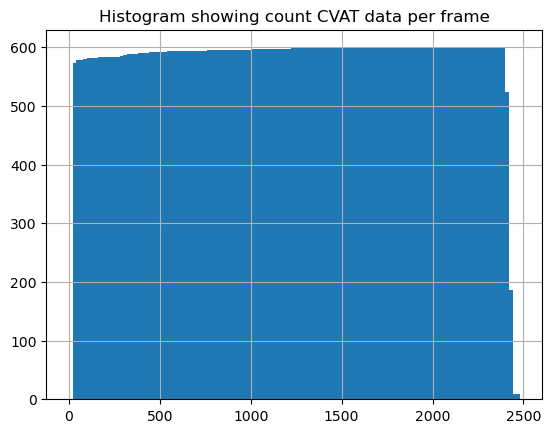

In [28]:
# to check if all went well: 
plt.title('Histogram showing count CVAT data per frame')
cvat_df.frame.hist(bins=range(0,2500,20))
# should be more or less stable between 0 and 2400 for 2 minute videos.

<Axes: title={'center': 'Histogram showing count ArUco marker data per frame'}>

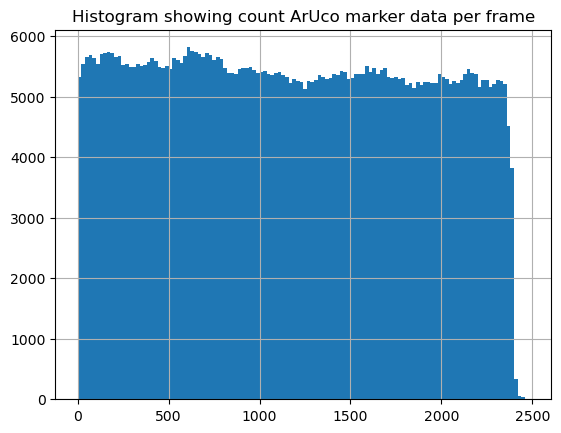

In [29]:
plt.title('Histogram showing count ArUco marker data per frame')
ArUco_df.frame.hist(bins=range(0,2500,20))

we have seen that the CVAT annotations were done at 1Hz (which is a massive workload already for annotators) and the ArUco data at 20Hz. Therefore we first change the frame numbers to the same actual frames in the file. We skipped to every 20th frame in annotation (or to the frame corresponding to the frequency), so we convert it back to the frame in the original video.


# 2.3 Combining Data - merge CVAT and ArUco
Here we merge them into one data frame with the original name of df


In [30]:
# first we select the columns to merge on. the keys from the overview file are in both already.
# Important: we merged the column ID in both frames to a different ID column in the overview file for both. 
# We shall thus never use the key: 'ID' but always 'ID_CVAT' or 'ID_ArUco' from now on.
common_cols = conv_df.keys().to_list()
col_list = common_cols + ['video', 'frame']
# now we merge them into the dataframe called df.
df = ArUco_df.merge(cvat_df, on=col_list, how='outer')
# the frame now reached a size where it's difficult to know which keys exist. We print those first
print(df.keys())

Index(['frame', 'ID_x', 'top_left', 'top_right', 'bottom_right', 'bottom_left',
       'path_and_filename_x', 'video', 'tl_x', 'tl_y', 'tr_x', 'tr_y', 'br_x',
       'br_y', 'bl_x', 'bl_y', 'video_name', 'original_video', 'part',
       'start_time', 'task_CVAT', 'Hz_CVAT', 'annotator', 'checked',
       'duration_sec', 'video_available', 'pen', 'breed', 'nr_animals',
       'ID_CVAT', 'ID_ArUco', 'marker_obstructed', 'Unnamed: 0',
       'video_sep_name', 'pen_corner_tl_x', 'pen_corner_tl_y',
       'pen_corner_tr_x', 'pen_corner_tr_y', 'pen_corner_br_x',
       'pen_corner_br_y', 'pen_corner_bl_x', 'pen_corner_bl_y', 'x_ArUco',
       'y_ArUco', 'Inside_Polygon', 'max_frame', 'frame_tracked', 'ID_y',
       'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'class',
       'visible', 'path_and_filename_y', 'frame_CVAT'],
      dtype='object')


In [31]:
df.sample(25)
# NOTE: evey 20th frame was annotated so taking 25, we expect a lot of nan values at the last columns

,frame,ID_x,top_left,top_right,bottom_right,bottom_left,path_and_filename_x,video,tl_x,tl_y,...,ID_y,bb_left,bb_top,bb_width,bb_height,conf,class,visible,path_and_filename_y,frame_CVAT
330896,2028.0,19.0,"(1692.0, 776.0)","(1698.0, 813.0)","(1662.0, 818.0)","(1657.0, 781.0)",ArUco/05_20220108114710_part_2_ArUco_tracks.csv,05_20220108114710_part_2,1692.0,776.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
617890,1854.0,7.0,"(1207.0, 605.0)","(1180.0, 621.0)","(1165.0, 596.0)","(1191.0, 580.0)",ArUco/p01t_07_20220102074423_2_ArUco_tracks.csv,p01t_07_20220102074423_2,1207.0,605.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151022,256.0,11.0,"(1223.0, 271.0)","(1215.0, 300.0)","(1186.0, 294.0)","(1194.0, 264.0)",ArUco/01_20220110073318_3_ArUco_tracks.csv,01_20220110073318_3,1223.0,271.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142320,1270.0,11.0,"(1281.0, 472.0)","(1254.0, 487.0)","(1239.0, 461.0)","(1266.0, 446.0)",ArUco/01_20220110073318_1_ArUco_tracks.csv,01_20220110073318_1,1281.0,472.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356965,2358.0,13.0,"(1517.0, 949.0)","(1531.0, 919.0)","(1566.0, 927.0)","(1552.0, 957.0)",ArUco/06_20211217112157_part1_1_ArUco_tracks.csv,06_20211217112157_part1_1,1517.0,949.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200059,1485.0,1.0,"(814.0, 570.0)","(813.0, 602.0)","(783.0, 602.0)","(783.0, 570.0)",ArUco/02_20220111065955_part2_WB_ArUco_tracks.csv,02_20220111065955_part2_WB,814.0,570.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
507767,1613.0,17.0,"(482.0, 977.0)","(475.0, 951.0)","(490.0, 944.0)","(498.0, 970.0)",ArUco/07_20220108115953_part2_5_ArUco_tracks.csv,07_20220108115953_part2_5,482.0,977.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395060,2186.0,17.0,"(489.0, 688.0)","(469.0, 668.0)","(487.0, 648.0)","(506.0, 668.0)",ArUco/06_20211217112157_part1_4_ArUco_tracks.csv,06_20211217112157_part1_4,489.0,688.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428858,312.0,12.0,"(1375.0, 528.0)","(1358.0, 554.0)","(1335.0, 538.0)","(1351.0, 512.0)",ArUco/06_20211217112157_part1_7_ArUco_tracks.csv,06_20211217112157_part1_7,1375.0,528.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330649,1557.0,19.0,"(1700.0, 772.0)","(1702.0, 813.0)","(1667.0, 809.0)","(1665.0, 773.0)",ArUco/05_20220108114710_part_2_ArUco_tracks.csv,05_20220108114710_part_2,1700.0,772.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
next part:
***

# Part 3

# 3.1 Data processing before final examination of tracking quality

- 3.1 cleaning of merged df
- 3.2 remove left-over double annotations
- 3.3 interpolate visibility from annotations over marker tracking data
- 3.4 initial insights in data frame focussed on filtering methods





## 3.1 cleaning of merged df

### 3.1.A dropping empty rows

In [32]:
# here we drop all data - if left which is not merged to an annotated ID or a frame.
# there should not be any but let's just be sure.
print('current shape of the data is: ',df.shape)
df = df.dropna(subset=['ID_CVAT', 'frame'])
print('shape after deleting unexpected columns, should be the same: ', df.shape)

current shape of the data is:  (687903, 57)
shape after deleting unexpected columns, should be the same:  (687903, 57)


### 3.1.B aligning frame number CVAT and Bounding Boxes

In [33]:
# in 2 steps we find the frame number of the annotated frame which the frame of the ArUco tracking corresponds to
# step 1: we divide by the
df['corresponding_annotated_frame'] = (df['frame'] - (df['frame']%(20/df['Hz_CVAT'])))/20
# step 2: annotation frame rate was often 1 Hz but sometimes more.
# if we originally had a high annotation frame rate, we might end up with non-whole numbers so we ceil
df['corresponding_annotated_frame'] = df['corresponding_annotated_frame'\
                                        ].apply(lambda x: math.ceil(x) if str(x) != 'nan' else np.nan)

### 3.1.C new columns for bounding boxes (CVAT)
Similar to what we did for the ArUco data in cell 2.2.A.1 we take 1 coordinate instead of the corners for the bounding box annotations from the CVAT dataset

In [34]:
# since we had 4 coordinates (8 float values) per box and we want to use the middle value, we calculate.
df['x_BB'] = df['bb_left'] + (df['bb_width']/2)
df['y_BB'] = df['bb_top'] + (df['bb_height']/2)

## 3.2 filtering out remaining double ArUco positions
In the earlier merge of our ArUco data with the overview frame, we already removed all ArUco marker tracks which do not belong to one of our animals There should be very few occassions of multiple ArUco markers detected at the same time.


Now we only have to remove tracks of animals in our pens which are also noticed outside the pens. We do this by first selecting the double records and then selecting the ones further away to be removed.



### 3.2.A how large is the issue?

In [35]:
# in this plot we take a look at double occurances of markers.
count_ArUco_per_measurement = df.loc[(df['tl_x']>=0.0),['video', 'frame', 'ID_CVAT', 'ID_ArUco', 'tl_x']\
                                    ].groupby(['video', 'frame', 'ID_CVAT', 'ID_ArUco']).count().reset_index()
count_ArUco_per_measurement['double'] = count_ArUco_per_measurement['tl_x']
print('number of double detections: ', count_ArUco_per_measurement[count_ArUco_per_measurement['double']>1].shape[0])
print('percentage of total detections: ', count_ArUco_per_measurement[count_ArUco_per_measurement['double']>1].shape[0] / df.shape[0], '%')
count_ArUco_per_measurement[count_ArUco_per_measurement['double']>1]

number of double detections:  36
percentage of total detections:  5.2332959734148565e-05 %


,video,frame,ID_CVAT,ID_ArUco,tl_x,double
1590,01_20220108115951_part1_1,276.0,1.0,12.0,2,2
20608,01_20220108115951_part1_2,1054.0,5.0,6.0,2,2
68885,01_20220108115951_part1_5,252.0,5.0,9.0,2,2
69929,01_20220108115951_part1_5,376.0,7.0,2.0,2,2
75218,01_20220108115951_part1_5,1097.0,6.0,12.0,2,2
82743,01_20220108115951_part1_5,2148.0,8.0,5.0,2,2
82947,01_20220108115951_part1_5,2175.0,4.0,1.0,2,2
85855,01_20220108115951_part1_6,141.0,1.0,1.0,2,2
92477,01_20220108115951_part1_6,1151.0,3.0,2.0,2,2
93445,01_20220108115951_part1_6,1290.0,8.0,8.0,2,2


In [36]:
df.shape[0]
# df.shape[1]

687903

### 3.2.B functions to find double ArUco detections for identified animals


In [37]:
# here again (in a different way) we make a frame with the double measurements
df_double = df[df[['video', 'frame','ID_CVAT','ID_ArUco']].duplicated(keep=False) == True]
# since we take a subset out of the original frame, we will get an error to use .loc at every action from now
# therefore we just take a copy and merge later on. Of course we could use .loc but the code would be unnecessarily long.
df_double = df_double.copy(deep=True)

def return_BB_x_values(video, frame, ID_CVAT):
    cor_BB_x_y = df.loc[(df['video']==video)&\
                        (df['frame_tracked']==float(frame))&\
                        (df['ID_CVAT']==ID_CVAT),['x_BB', 'y_BB']
                       ].values[0]
    return float(cor_BB_x_y[0])

def return_BB_y_values(video, frame, ID_CVAT):
    cor_BB_x_y = df.loc[(df['video']==video)&\
                        (df['frame_tracked']==float(frame))&\
                        (df['ID_CVAT']==ID_CVAT),['x_BB', 'y_BB']\
                       ].values[0]
    return float(cor_BB_x_y[1])

df_double.loc[:,'cor_BB_x']= df_double.apply(lambda x: \
                                             return_BB_x_values(x.video, x.corresponding_annotated_frame, x.ID_CVAT), axis=1)
df_double.loc[:,'cor_BB_y']= df_double.apply(lambda x:\
                                             return_BB_y_values(x.video, x.corresponding_annotated_frame, x.ID_CVAT), axis=1)

### 3.2.C find the distances between the double ArUcos and the corresponding bounding boxes

In [38]:
df_double.loc[:,'dist_BB_ArUco'] = np.sqrt((df_double.cor_BB_x - df_double.tl_x)**2\
                                           + (df_double.cor_BB_y - df_double.tl_y)**2)
df_double

,frame,ID_x,top_left,top_right,bottom_right,bottom_left,path_and_filename_x,video,tl_x,tl_y,...,class,visible,path_and_filename_y,frame_CVAT,corresponding_annotated_frame,x_BB,y_BB,cor_BB_x,cor_BB_y,dist_BB_ArUco
274,276.0,12.0,"(213.0, 754.0)","(224.0, 732.0)","(245.0, 748.0)","(233.0, 769.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,213.0,754.0,...,NaN,NaN,NaN,NaN,14,NaN,NaN,358.210,834.350,165.958027
275,276.0,12.0,"(1157.0, 774.0)","(1144.0, 818.0)","(1098.0, 798.0)","(1101.0, 770.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,1157.0,774.0,...,NaN,NaN,NaN,NaN,14,NaN,NaN,358.210,834.350,801.066531
17325,1054.0,6.0,"(258.0, 564.0)","(251.0, 538.0)","(273.0, 528.0)","(281.0, 554.0)",ArUco/01_20220108115951_part1_2_ArUco_tracks.csv,01_20220108115951_part1_2,258.0,564.0,...,NaN,NaN,NaN,NaN,52,NaN,NaN,269.050,547.350,19.983118
17326,1054.0,6.0,"(1080.0, 606.0)","(1125.0, 619.0)","(1098.0, 674.0)","(1074.0, 666.0)",ArUco/01_20220108115951_part1_2_ArUco_tracks.csv,01_20220108115951_part1_2,1080.0,606.0,...,NaN,NaN,NaN,NaN,52,NaN,NaN,269.050,547.350,813.068094
69152,2175.0,1.0,"(433.0, 854.0)","(430.0, 826.0)","(456.0, 825.0)","(459.0, 853.0)",ArUco/01_20220108115951_part1_5_ArUco_tracks.csv,01_20220108115951_part1_5,433.0,854.0,...,NaN,NaN,NaN,NaN,108,NaN,NaN,568.405,825.825,138.305259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551185,1451.0,20.0,"(1378.0, 743.0)","(1358.0, 720.0)","(1380.0, 702.0)","(1400.0, 725.0)",ArUco/10_20220108115949_part2_6_ArUco_tracks.csv,10_20220108115949_part2_6,1378.0,743.0,...,NaN,NaN,NaN,NaN,72,NaN,NaN,1326.600,738.450,51.600993
557128,2355.0,13.0,"(871.0, 941.0)","(857.0, 969.0)","(829.0, 955.0)","(843.0, 926.0)",ArUco/11_20220108105951_part1_1_ArUco_tracks.csv,11_20220108105951_part1_1,871.0,941.0,...,NaN,NaN,NaN,NaN,117,NaN,NaN,866.500,911.000,30.335623
557129,2355.0,13.0,"(1048.0, 812.0)","(1017.0, 762.0)","(1058.0, 744.0)","(1071.0, 803.0)",ArUco/11_20220108105951_part1_1_ArUco_tracks.csv,11_20220108105951_part1_1,1048.0,812.0,...,NaN,NaN,NaN,NaN,117,NaN,NaN,866.500,911.000,206.744407
563518,811.0,13.0,"(1425.0, 525.0)","(1447.0, 510.0)","(1461.0, 535.0)","(1440.0, 551.0)",ArUco/11_20220108105951_part1_2_ArUco_tracks.csv,11_20220108105951_part1_2,1425.0,525.0,...,NaN,NaN,NaN,NaN,40,NaN,NaN,1430.015,531.310,8.060169


### 3.2.D select just the double marker detections and merge them to df to delete later

In [39]:
gb_select_double = df_double.loc[:,['video', 'frame', 'ID_CVAT', 'dist_BB_ArUco']\
                                ].groupby(['video', 'frame', 'ID_CVAT']\
                                          ).max().reset_index()
gb_select_double['delete'] = True
df_select_double = df_double.merge(gb_select_double,\
                                   on=['video', 'frame', 'ID_CVAT', 'dist_BB_ArUco'\
                                      ], how='outer')

In [40]:
on_keys = list(df_select_double.keys()[:-4])
df = df.merge(df_select_double, on=on_keys, how='outer')
df.head()

,frame,ID_x,top_left,top_right,bottom_right,bottom_left,path_and_filename_x,video,tl_x,tl_y,...,visible,path_and_filename_y,frame_CVAT,corresponding_annotated_frame,x_BB,y_BB,cor_BB_x,cor_BB_y,dist_BB_ArUco,delete
0,1.0,12.0,"(292.0, 849.0)","(289.0, 821.0)","(308.0, 818.0)","(311.0, 847.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,292.0,849.0,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,12.0,"(292.0, 849.0)","(289.0, 821.0)","(307.0, 818.0)","(311.0, 846.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,292.0,849.0,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,12.0,"(293.0, 849.0)","(289.0, 821.0)","(308.0, 818.0)","(311.0, 846.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,293.0,849.0,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,12.0,"(293.0, 849.0)","(290.0, 821.0)","(308.0, 818.0)","(312.0, 845.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,293.0,849.0,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,12.0,"(294.0, 848.0)","(290.0, 820.0)","(309.0, 817.0)","(312.0, 845.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,294.0,848.0,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2.E remove double values:

In [41]:
# finally we remove the rows with the double data.
df = df[df['delete'].isna()]

## 3.3 interpolate annotated visibility to quantify the marker visibility for available data

In this part we add a value for visibility from the annotated CVAT data to the ArUco marker tracking data.

Interpolation can be done multiple ways, so we consider this the first moment of data filtering. We interpolate with the nearest method.

In [42]:
# I want to know if an ArUco measurement is on a visible or unvisible animal
# visible has 1 for visible, 0 for not and np.nan for no measurement (now it is nan 19 out of 20 frames)
df_list = []
df.loc[(df['visible']>=0.0), 'cvat_data'] = True
# then we interpolate the data and round to the nearest 0 or 1
df = df.sort_values(by=['video_name', 'ID_CVAT', 'frame']).reset_index()

# our plan is to sort and interpolate to get values for visibility from the CVAT to the ArUco data
# if we simply sort and interpolate, the first and last values (20 out of the range 120-2400) will be connected to another ID
# for the small amounts of data that come with manual annotations, 
# we cannot assume the incorrect interpolated numbers to be negligible
# therefore we interpolate the visibility per video, per CVAT_ID (which is always known, ArUco ID is not).

# one challenge with the interpolation function is that nearest interpolation works after the last value, -
# -but interpolating before the first value is not. Therefore we add a number for the first value.

def interpolate_visibility(subdf):
    if subdf.loc[(subdf['visible']>=0.0), 'visible'].shape[0] <=1:
        subdf['visible_inter'] = subdf['visible']
        df_list.append(subdf)
    else:
        # we place the first value for visibility at the first measured position
        # first we find the first frame with a record (differs per animal)
        first_frame = subdf.loc[:, 'frame'].min() 
        # if at that frame, data is missing, we make it the next value:
        if np.isnan(subdf.loc[(subdf['frame']==first_frame),\
                              'visible'].values[0]):
            subdf.loc[(subdf['frame']==first_frame), 'visible'\
                     ] = subdf.loc[(subdf['visible']>=0.0), 'visible'].values[0]
        # and now we interpolate to the nearest
        subdf.loc[:, 'visible_inter'] = subdf.visible.interpolate(method='nearest', fill_value='extrapolate')
#         print(subdf.loc[:,['frame', 'ID_CVAT','visible','visible_inter', 'tl_x']][:30])
#         print(subdf.loc[:,['frame', 'ID_CVAT','visible','visible_inter', 'tl_x']][-30:])
    df_list.append(subdf)

print('Shape before groupby apply and concat: ', df.shape)
df.groupby(['video', 'ID_CVAT']).apply(lambda x: interpolate_visibility(x))
df = pd.concat(df_list)
print('Shape after groupby apply and concat: ', df.shape, ' which should be the same nr of rows and one column more')
df.head()

Shape before groupby apply and concat:  (687860, 66)
Shape after groupby apply and concat:  (687860, 67)  which should be the same nr of rows and one column more


,index,frame,ID_x,top_left,top_right,bottom_right,bottom_left,path_and_filename_x,video,tl_x,...,frame_CVAT,corresponding_annotated_frame,x_BB,y_BB,cor_BB_x,cor_BB_y,dist_BB_ArUco,delete,cvat_data,visible_inter
0,0,1.0,12.0,"(292.0, 849.0)","(289.0, 821.0)","(308.0, 818.0)","(311.0, 847.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,292.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,2.0,12.0,"(292.0, 849.0)","(289.0, 821.0)","(307.0, 818.0)","(311.0, 846.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,292.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2,3.0,12.0,"(293.0, 849.0)","(289.0, 821.0)","(308.0, 818.0)","(311.0, 846.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,293.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,3,4.0,12.0,"(293.0, 849.0)","(290.0, 821.0)","(308.0, 818.0)","(312.0, 845.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,293.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,4,5.0,12.0,"(294.0, 848.0)","(290.0, 820.0)","(309.0, 817.0)","(312.0, 845.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,294.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


# 3.4 final look on the data before export

In [43]:
original_nr_ArUco_p_vid = copy_complete_ArUco[['video', 'ID']\
                                             ].groupby(['video']\
                                                      ).nunique().reset_index()['ID'].sum()
print('original sum of all recognized ArUco IDs over all videos is: ', original_nr_ArUco_p_vid)

# since we don't have the original video in the old dataset, 
# - we merge just that column for now if not ran before.
frame_vid_ori = conv_df[['video_name','original_video']].groupby('video_name').first().reset_index()

if 'original_video' not in copy_complete_ArUco.keys():
    copy_complete_ArUco = copy_complete_ArUco.merge(frame_vid_ori[['video_name','original_video']],\
                                                    left_on='video', \
                                                    right_on='video_name',\
                                                    how='left')

original_nr_ArUco_p_original_vid = copy_complete_ArUco[['original_video', 'ID']\
                                                      ].groupby(['original_video']).nunique().reset_index()['ID'].sum()

print('original sum of all recognized ArUco IDs over all original videos is: ', original_nr_ArUco_p_original_vid)


corrected_nr_ArUco_p_vid = ArUco_df[['video', 'ID_ArUco']\
                                   ].groupby(['video']).nunique().reset_index()['ID_ArUco'].sum()
print('after merging with observed ArUco IDs, the sum of all recognized IDs over all videos:', corrected_nr_ArUco_p_vid)


corrected_nr_ArUco_p_original_vid = ArUco_df[['original_video', 'ID_ArUco']\
                                            ].groupby(['original_video']).nunique().reset_index()['ID_ArUco'].sum()
print('after merging with observed IDs, the sum of all recognized ArUco IDs over the original videos:',\
      corrected_nr_ArUco_p_original_vid)

original_dataset_size = copy_complete_ArUco.shape[0]
corrected_dataset_size = ArUco_df.shape[0]

print('original dataset had ', original_dataset_size,' rows, but after removing tracking data outside the pen there are ', corrected_dataset_size)
percentage_data_left = round(corrected_dataset_size / original_dataset_size * 100, 1)
print('this is ', percentage_data_left, '% of the original')

original sum of all recognized ArUco IDs over all videos is:  667
original sum of all recognized ArUco IDs over all original videos is:  212
after merging with observed ArUco IDs, the sum of all recognized IDs over all videos: 448
after merging with observed IDs, the sum of all recognized ArUco IDs over the original videos: 104
original dataset had  689252  rows, but after removing tracking data outside the pen there are  648815
this is  94.1 % of the original


Text(0.5, 1.0, 'original (black) and filtered (red) marker coordinates and bounding boxes (green)')

C:\Users\Putte027\AppData\Local\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Putte027\AppData\Local\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


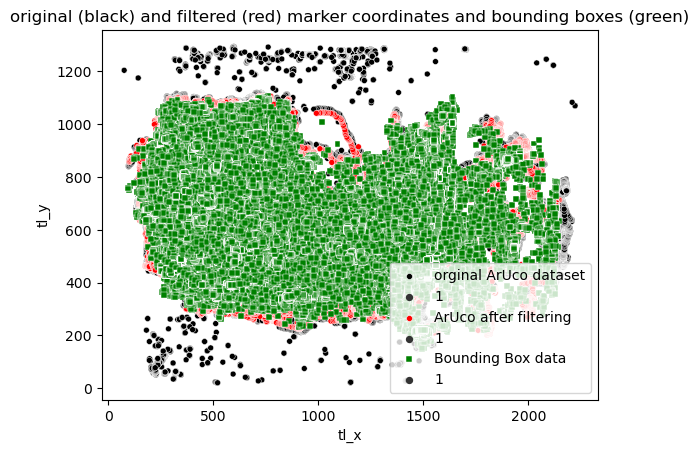

In [44]:
sns.scatterplot(data=copy_complete_ArUco, x="tl_x", y="tl_y", color='black', size=1, label='orginal ArUco dataset')
sns.scatterplot(data=df, x="x_ArUco", y="y_ArUco", color='red', size=1, label='ArUco after filtering')
sns.scatterplot(data=df, x="x_BB", y="y_BB", color='green', size=1, marker='s', label='Bounding Box data')
plt.legend()
plt.title('original (black) and filtered (red) marker coordinates and bounding boxes (green)')

Interpretation:
Above we see a scatter of all positions of the bounding boxes as well as the ArUco markers. The scatter does not consider slightly turned cameras, so the combination of data is not an exact square.

From all positions, we can already distinguish the position of the feeder (top middle) where animals cannot stand and the right side has perches so the area between the perches and the floor is not a place where we expect many points.

We took the average position of the marker and the bounding boxes to compare. What we see is that the red and green points do not completely overlap. We know that the marker is not placed exactly in the middle of the bounding box but the locations should be close.

Text(0.5, 1.0, 'ArUco marker locations after 2 steps of filtering')

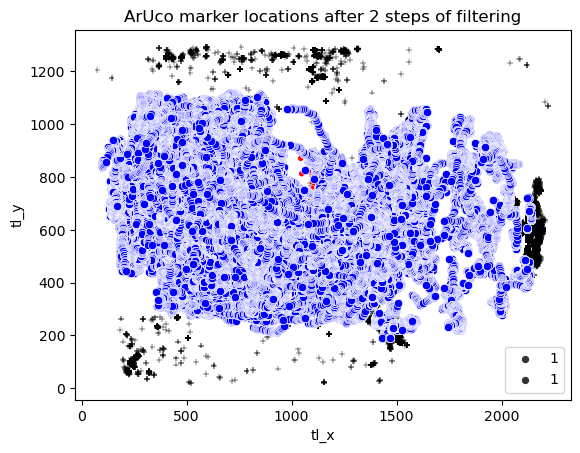

In [45]:
sns.scatterplot(data=copy_complete_ArUco, x="tl_x", y="tl_y", color='black', size=1, marker = '+')
sns.scatterplot(data= ArUco_df, x="tl_x", y="tl_y", color='red', size=1)
sns.scatterplot(df, x='tl_x', y='tl_y', color='blue')
plt.title('ArUco marker locations after 2 steps of filtering')

#### interpreting the location plot
We can again see the locations, with the black points being filtered out. Also, we see a few red points of double detections on the feeder. This originates from a handful of frames where the squares in the feeder were recognized as ArUco markers, but the number there is negligible.

By filtering, we accidentally removed some of the ArUco data on the right. However, for the data outside the pen on the top and the bottom it worked quite well.


## overview of the columns
#### specific for cvat data:
- frame_tracked: the annotated frame number in cvat. Annotations were done mostly at 1Hz from the 20fps video. This means that every increase of 1 here corresponds to the 20th frame from the previous.

- ID: we have multiple. the column ID represents the local id given in cvat or the ArUco marker number in the ArUco dataset.

- ID_CVAT: the local id given during annotation

- bb_left, bb_top, bb_width, bb_height: x, y and size of the bounding box from the annotations in CVAT.

- conf, class: default output of our annotation software CVAT. If multiple classes would be used, this would be of importance. We don't use them

- visible: visible = 1 is the animal is clearly visible. visible = 0 if the animal is partly obstructed from view. No record if the animal is not at all visible.

- path_and_filename: complete path to the file. This is added so we can concatenate all files in a single line and still know which video the data belongs to.
made by us:
- frame : the annotated frame number converted to the actual frame number in the video (equal to ArUco frame number) by multiplying it to the Hz of the annotation.


#### specific for ArUco data:
- time_MS: time in milliseconds from the start of the video for every measurement

- ID_ArUco: the ArUco ID belonging to a specific marker.

- frame: number of the frame, fps and Hz of measurements do not measure

- top_left, top_right, bottom_right, bottom_left: (x, y) tuple with coordinates per marker corner

- tl_x, tl_y, tr_x, tr_y, br_x, br_y, bl_x, bl_y: marker corner locations from the 4 tuples split in 8 usable columns

- path_and_filename: complete path to the file. This is added so we can concatenate all files in a single line and still know which video the data belongs to.



#### Overview_file: 
- video/video_name: the name of the video taken from the path without '.mp4'

- original_video: videos were cut into multiple parts to keep annotation work managable. We have the original video to combine fragments originating from the same video.

- Hz_CVAT: the number of frames per second annotated.

- part: the part of the original video. If we would like, this enables us to calculate back to real time.

- start_time: our original videos are labeled as follows: < channel>_< year>< month>< day>< hour>< minute>< second>_part< part_number>.mp4 which means that if we use part 2, the time we can extract from the title belongs to part 1. It's easiest just to open this set of videos and read the start time from the time printed on top of the video. This time is in seconds so the data can differ up to a second from the real time.

- task_CVAT: task number belonging to the video, to link to the status of the video in the annotation process.\

- annotator: person who did the original annotation

- checked: if the frames are checked.

- duration_sec: the duration in seconds of the video fragment as seen with our file explorer.

- video_available: True if the file is available to us.

- pen: the enclosure/cage/aviary the group of animals is housed in

- breed: the layer hybrid used. In this experiment Dekalb White (DW) or ISA Brown (IB)

#### made in this script
- visible_inter: Interpolated visibility from the CVAT dataset to the ArUco dataset. The nearest method is used. Since on the video we already noticed the ArUco tracking not to be perfect, we would throw away too much data by only using 1/20th of the data where we also know that the ArUco shows sometimes only. In the interpolation process, we interpolate between all available points, but since the ArUco data often overlaps the CVAT data, we need to consider the ends. The nearest method allows for 

- marker_obstructed: if the letter u is added in the overview file, linking the ArUco to the CVAT ID, then the animal is visible but the ArUco can never be read. We add True if obstructed.

- max_frame: the highest frame number in the annotation in a video. Since annotation frequency differs from ArUco frequency, we limit the ArUco dataset (which could be larger) to the size of the CVAT dataset. This allows for comparison.

### result columns
- tl_x: count of ArUco data per groupby element. If tl_x is present, the other 7 are as well.

- bb_top: count of CVAT data per groupby element. If bb_top is present, the other 3 are as well.

- visible_with_ArUco, visible_without_ArUco, not_visible_with_ArUco, not_visible_without_ArUco: the count of all available data (cvat and ArUco positions) if the interpolated visibility is True/False and availability of ArUco data is True/False. These 4 options add up to the total nr of records in the column 
- perc_ -> visible_with_ArUco, visible_without_ArUco, not_visible_with_ArUco, not_visible_without_ArUco: the 

Columns exported:

'video', 'original_video', 'ID_CVAT', 'ID_ArUco', 'pen', 'breed',
       'Hz_CVAT', 'visible', 'visible_inter', 'frame', 'frame_tracked', 'tl_x',
       'bb_top', 'count_BB_annotations_visible',
       'count_BB_annotations_not_visible', 'visible_with_ArUco',
       'visible_without_ArUco', 'not_visible_with_ArUco',
       'not_visible_without_ArUco', 'max_frame', 'ArUco_missing'


'', '', '', 'visible_inter', 'frame',
       'frame_tracked', 'tl_x', 'bb_top', 'count_BB_annotations_visible',
       'count_BB_annotations_not_visible', 'visible_with_ArUco',
       'visible_without_ArUco', 'not_visible_with_ArUco',
       'not_visible_without_ArUco', 'ArUco_missing', 'perc_visible_with_ArUco',
       'perc_visible_without_ArUco', 'perc_not_visible_with_ArUco',
       'perc_not_visible_without_ArUco', 'nr_animals', 'nr_ArUco', 'breed',
       'Hz_CVAT', 'true_nr_animals', 'total_frames_per_original_video',
       'nr_marker_tracks_expected', 'missing_marker_tracks',
       'perc_missing_marker_tracks', 'nr_expected_annotations',
       'nr_of_annotations', 'missing_annotations', 'perc_missing_annotations',
       'perc_annotation_obstructed', 'perc_annotation_not_obstructed'

## filtering out the double annotations




## remove the double ArUco tracks outside of the pen

In this experiment, nearby groups of hens could be seen with the camera aimed at a pen. The ArUco markers were just small enough the be recognized through the maze of the fence. Therefore double ArUco detections are possible and they do occur. In order to see how to deal with them, we first have to plot the data.
If we would want to do it perfectly, then for every ArUco marker we would check if it is within an (interpolated) bounding box or close to one.

for every frame we take the corresponding cvat frame

frame with row for every video, for every range of frames, for every CVAT_ID

In [46]:
# here we print the frame
df.loc[:,['frame_tracked', 'bb_top', 'visible','frame', 'visible_inter', 'tl_x', 'ID_CVAT', 'ID_ArUco', 'video']].sample(50)

,frame_tracked,bb_top,visible,frame,visible_inter,tl_x,ID_CVAT,ID_ArUco,video
329443,NaN,NaN,NaN,251.0,1.0,467.0,6.0,6.0,03_20220108075951_part2_6
239391,NaN,NaN,NaN,1652.0,1.0,705.0,2.0,3.0,02_20220111112402_part2
646606,NaN,NaN,NaN,2174.0,1.0,564.0,4.0,10.0,p01t_07_20220102074423_2
6690,NaN,NaN,NaN,286.0,1.0,1293.0,4.0,4.0,01_20220108115951_part1_1
650431,NaN,NaN,NaN,956.0,1.0,746.0,7.0,9.0,p01t_07_20220102074423_2
625035,NaN,NaN,NaN,1162.0,1.0,768.0,8.0,20.0,11_20220108105951_part1_4
280858,NaN,NaN,NaN,624.0,1.0,581.0,6.0,7.0,03_20220108075951_part2_3
682651,NaN,NaN,NaN,406.0,1.0,781.0,3.0,11.0,p02t_06_20220112171551_3
683835,82.0,503.5,1.0,1640.0,1.0,938.0,3.0,11.0,p02t_06_20220112171551_3
587695,NaN,NaN,NaN,2141.0,1.0,826.0,3.0,13.0,11_20220108105951_part1_1


In [50]:
# since it takes so long to get here, we export
df.to_csv(workdir + 'df.csv')
# df = pd.read_csv(workdir + 'df.csv')
df

,index,frame,ID_x,top_left,top_right,bottom_right,bottom_left,path_and_filename_x,video,tl_x,...,frame_CVAT,corresponding_annotated_frame,x_BB,y_BB,cor_BB_x,cor_BB_y,dist_BB_ArUco,delete,cvat_data,visible_inter
0,0,1.0,12.0,"(292.0, 849.0)","(289.0, 821.0)","(308.0, 818.0)","(311.0, 847.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,292.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,2.0,12.0,"(292.0, 849.0)","(289.0, 821.0)","(307.0, 818.0)","(311.0, 846.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,292.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2,3.0,12.0,"(293.0, 849.0)","(289.0, 821.0)","(308.0, 818.0)","(311.0, 846.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,293.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,3,4.0,12.0,"(293.0, 849.0)","(290.0, 821.0)","(308.0, 818.0)","(312.0, 845.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,293.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,4,5.0,12.0,"(294.0, 848.0)","(290.0, 820.0)","(309.0, 817.0)","(312.0, 845.0)",ArUco/01_20220108115951_part1_1_ArUco_tracks.csv,01_20220108115951_part1_1,294.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687855,687898,2320.0,NaN,NaN,NaN,NaN,NaN,NaN,p02t_06_20220112171551_3,NaN,...,116.0,116,1900.65,859.05,NaN,NaN,NaN,NaN,True,1.0
687856,687899,2340.0,NaN,NaN,NaN,NaN,NaN,NaN,p02t_06_20220112171551_3,NaN,...,117.0,117,1902.55,864.05,NaN,NaN,NaN,NaN,True,1.0
687857,687900,2360.0,NaN,NaN,NaN,NaN,NaN,NaN,p02t_06_20220112171551_3,NaN,...,118.0,118,1904.10,869.05,NaN,NaN,NaN,NaN,True,1.0
687858,687901,2380.0,NaN,NaN,NaN,NaN,NaN,NaN,p02t_06_20220112171551_3,NaN,...,119.0,119,1905.05,866.25,NaN,NaN,NaN,NaN,True,1.0


In [51]:
df2 = pd.DataFrame([])
video_list = list(df.video.unique())
for video in video_list:
    # animals in that video:
    animals = df.loc[(df['video']==video),:].ID_CVAT.unique().tolist()
    # do not forget python indexing when making the time range:
    time_range = list(range(1, 1+int(df.loc[(df['video']==video),:].frame.max())))
    animal_df = pd.DataFrame(list(itertools.product(*[[str(video)], animals, time_range])\
                                 ), columns=['video', 'ID_CVAT', 'frame'])
    df2 = pd.concat([df2, animal_df])
    
conv_df['video'] = conv_df['video_name']
df2 = df2.merge(conv_df[['original_video', 'video', 'ID_CVAT', 'ID_ArUco', 'breed','start_time']])
    
df2 = df2.merge(df[['video', 'original_video', 'ID_CVAT', 'ID_ArUco', 'frame', \
                    'visible', 'x_BB', 'y_BB', 'x_ArUco', 'y_ArUco', 'max_frame']\
                  ], on=['video', 'original_video', 'frame', 'ID_CVAT', 'ID_ArUco'], how='left')

df2.sample(5)

,video,ID_CVAT,frame,original_video,ID_ArUco,breed,start_time,visible,x_BB,y_BB,x_ArUco,y_ArUco,max_frame
804341,06_20211217112157_part1_2,5.0,522,06_20211217112157_part1,15.0,IB,11:23:58,NaN,NaN,NaN,1436.25,250.75,2380.0
347599,02_20220111065954_part2_BD,4.0,700,02_20220111065954_part2,9999.0,IB,07:41:08,1.0,992.8,770.45,NaN,NaN,NaN
285113,02_20220111065954_part2_BA,8.0,934,02_20220111065954_part2,9999.0,IB,07:35:09,NaN,NaN,NaN,NaN,NaN,NaN
758135,06_20211217112157_part1_1,3.0,2376,06_20211217112157_part1,16.0,IB,11:21:57,NaN,NaN,NaN,988.75,490.50,2420.0
39550,01_20220108115951_part1_2,7.0,1151,01_20220108115951_part1,8.0,DW,12:01:51,NaN,NaN,NaN,421.25,614.00,2400.0


In [52]:
# since it takes so long to get here, we export
df2.to_csv(workdir + 'df2.csv')
# df = pd.read_csv(workdir + 'df.csv')
df2.sample(50)

,video,ID_CVAT,frame,original_video,ID_ArUco,breed,start_time,visible,x_BB,y_BB,x_ArUco,y_ArUco,max_frame
533030,03_20220108075951_part2_3,3.0,311,03_20220108075951_part2,4.0,DW,08:37:52,NaN,NaN,NaN,1254.50,603.25,2380.0
565937,03_20220108075951_part2_4,6.0,2278,03_20220108075951_part2,3.0,DW,08:39:52,NaN,NaN,NaN,NaN,NaN,NaN
257364,01_20220110073318_3,5.0,2125,01_20220110073318,16.0,IB,07:37:29,NaN,NaN,NaN,NaN,NaN,NaN
105080,01_20220108115951_part1_5,3.0,1641,01_20220108115951_part1,4.0,DW,12:07:50,NaN,NaN,NaN,964.25,514.75,2420.0
1340079,p01t_07_20220102074423_2,5.0,720,p01t_07_20220102074423,5.0,DW,07:46:22,1.0,697.50,474.95,708.00,470.00,2400.0
1149383,10_20220108115949_part2_3,4.0,2024,10_20220108115949_part2,20.0,IB,12:37:46,NaN,NaN,NaN,NaN,NaN,NaN
843880,06_20211217112157_part1_4,3.0,1801,06_20211217112157_part1,16.0,IB,11:27:58,NaN,NaN,NaN,544.00,767.50,2380.0
556233,03_20220108075951_part2_4,2.0,2094,03_20220108075951_part2,2.0,DW,08:39:52,NaN,NaN,NaN,739.50,1099.25,2380.0
912029,06_20211217112157_part1_7,5.0,570,06_20211217112157_part1,15.0,IB,11:33:59,NaN,NaN,NaN,NaN,NaN,NaN
363474,02_20220111065954_part2_BD,10.0,2055,02_20220111065954_part2,2.0,IB,07:41:08,NaN,NaN,NaN,NaN,NaN,NaN
